In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font)

In [38]:
# 데이터 로드 , 구조 확인
df = pd.read_csv('listings.csv.gz', compression='gzip')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25297 entries, 0 to 25296
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            25297 non-null  int64  
 1   listing_url                                   25297 non-null  object 
 2   scrape_id                                     25297 non-null  int64  
 3   last_scraped                                  25297 non-null  object 
 4   source                                        25297 non-null  object 
 5   name                                          25297 non-null  object 
 6   description                                   24879 non-null  object 
 7   neighborhood_overview                         14048 non-null  object 
 8   picture_url                                   25297 non-null  object 
 9   host_id                                       25297 non-null 

In [39]:

'''
price                   1박당 가격 (우리가 예측하려는 정답)
room_type               숙소 유형 (집 전체, 개인실, 다인실)
accommodates            최대 수용 가능 인원
bedrooms                침실 개수
beds                    침대 개수
review_scores_rating    전체 만족도 평점
neighbourhood_cleansed  표준화된 지역명
'''
# 정제
cols = [
        'price', 'room_type', 'accommodates', 'bedrooms', 'beds',
        'review_scores_rating', 'neighbourhood_cleansed'
    ]
df_eda = df[cols].copy()

# 결측치 처리
for col in ['bedrooms', 'beds']: # bedrooms, beds 부분 결측치 -> 중앙값으로 대체
    median_val = df_eda[col].median()
    df_eda[col] = df_eda[col].fillna(median_val)

# 리뷰 점수 없는 데이터 제거
rows_before = len(df_eda)
df_eda.dropna(subset=['review_scores_rating'], inplace=True) # 평점이 너무 중요하다 보니 중앙값으로 넣었다간 신뢰성 잃을 것 같음

df_eda = df_eda.dropna(subset=['price']) # price 결측 행 제거


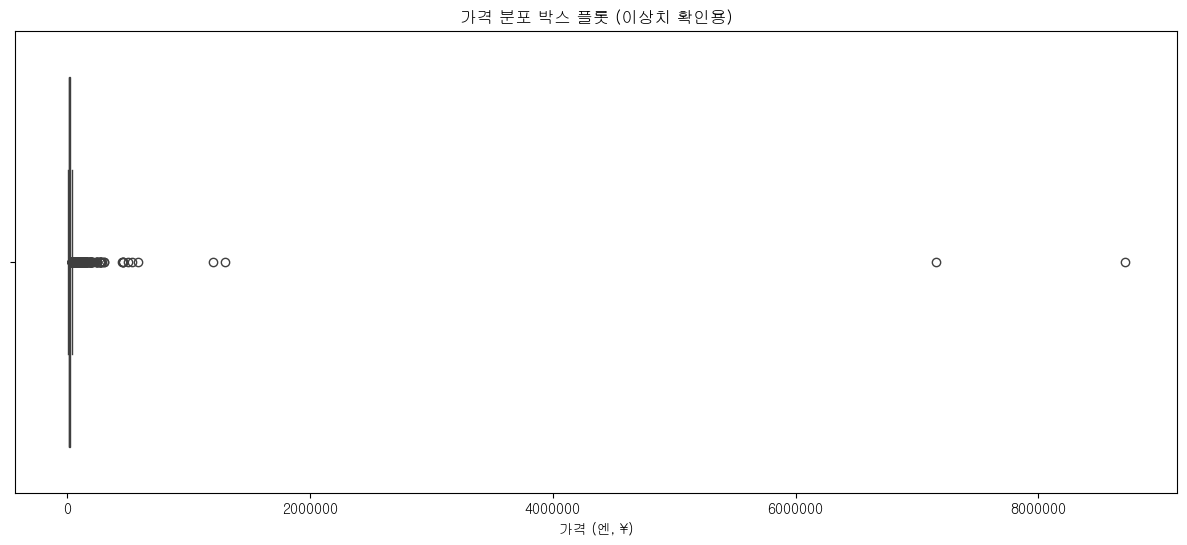

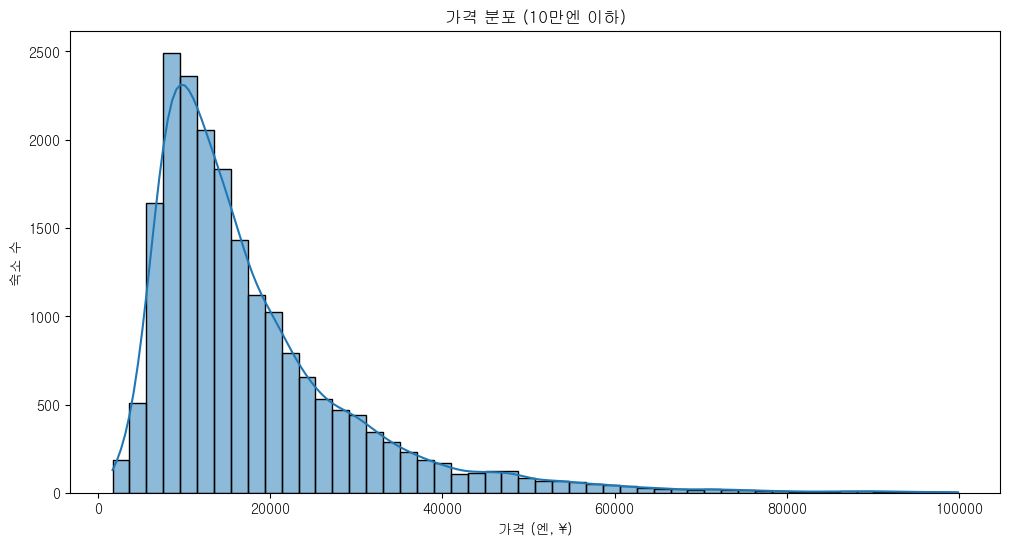

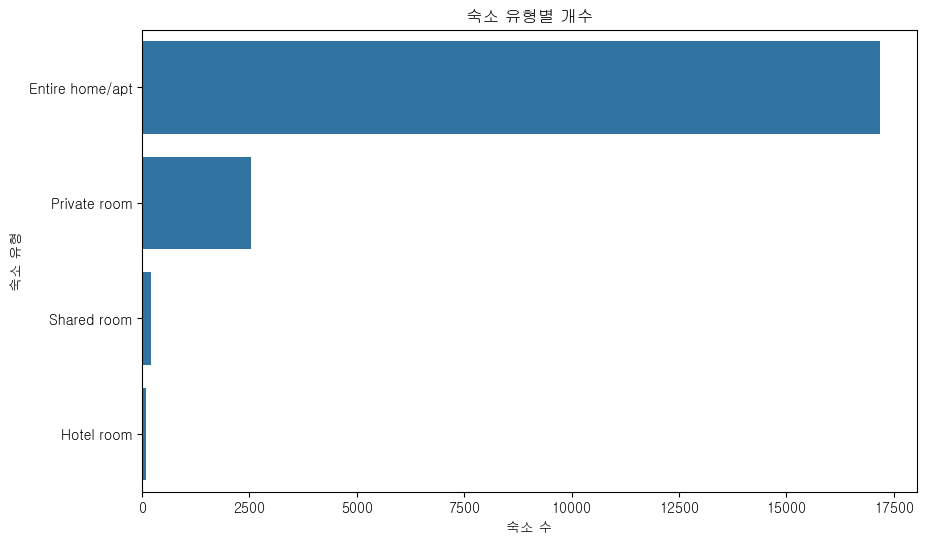

In [ ]:
 #데이터 탐색

# price 컬럼 숫자 형태로 변환
df_eda['price'] = df_eda['price'].str.replace('[$,]', '', regex=True).astype(float)

# 전체 가격 
plt.figure(figsize=(15, 6))
sns.boxplot(x=df_eda['price'])
plt.title('가격 분포 박스 플롯 (이상치 확인용)')
plt.xlabel('가격 (엔, ¥)')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# 10만엔 이하 필터하여 체크
plt.figure(figsize=(12, 6))
sns.histplot(df_eda[df_eda['price'] < 100000]['price'], bins=50, kde=True)
plt.title('가격 분포 (10만엔 이하)')
plt.xlabel('가격 (엔, ¥)')
plt.ylabel('숙소 수')
plt.show()

# 숙소 유형별 개수 
plt.figure(figsize=(10, 6))
sns.countplot(y='room_type', data=df_eda, order=df_eda['room_type'].value_counts().index)
plt.title('숙소 유형별 개수')
plt.xlabel('숙소 수')
plt.ylabel('숙소 유형')
plt.show()

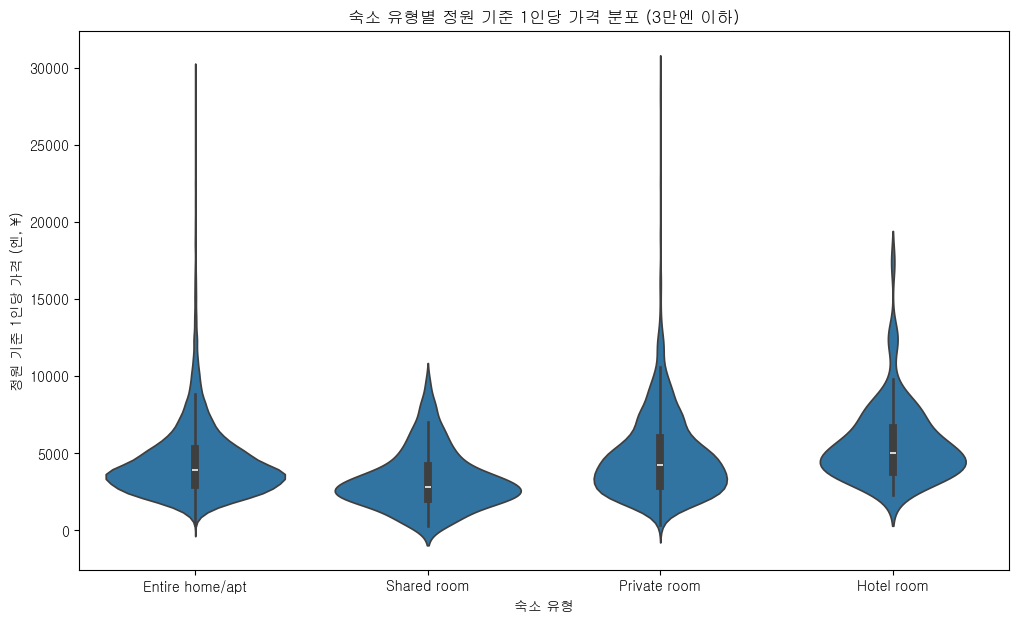

In [41]:
# 별개로 숙소 가성비 비교 칼럼 
df_eda['price_per_person'] = df_eda['price'] / df_eda['accommodates'] # 칼럼 생성 -> price / accommodates
df_eda['price_per_person'] = df_eda['price_per_person'].replace([np.inf, -np.inf], 0) # 기존 0 데이터가 무한대로 인식해서 0으로 수정
df_eda['price_per_person'] = df_eda['price_per_person'].fillna(0) # 빈칸을 0으로 

# 각 숙소 유형별로 어떤 가격에 몰려 있는지 확인
plt.figure(figsize=(12, 7))
sns.violinplot(x='room_type', y='price_per_person', data=df_eda[df_eda['price_per_person'] < 30000])
plt.title('숙소 유형별 정원 기준 1인당 가격 분포 (3만엔 이하)')
plt.xlabel('숙소 유형')
plt.ylabel('정원 기준 1인당 가격 (엔, ¥)')
plt.show()


In [42]:
# 모델링

X = df_eda.drop('price', axis=1)
y = df_eda['price']

X_encoded = pd.get_dummies(X, columns=['room_type', 'neighbourhood_cleansed'], drop_first=True) 
# roomtype 이 비교 했을때 제일 중요 할 거 같음

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16013, 56) (16013,)
(4004, 56) (4004,)


In [43]:
# 모델 훈련 및 평가

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

score = lr.score(X_test, y_test)

print(score)

0.05119574839327212
